# Исследование продаж компьютерных игр

**Задача:** Необходимо исследовать исторические данные о продажах игр из открытых источников, чтобы определелить, что определяет успешность игры.

**План проекта:**

1. Обзор данных
2. Предобработка данных
3. Исследовательский анализ данных
    - продажи игр в разные годы
    - влияют ли отзывы пользователей и критиков на продажи игр
    - распределение игр по жанрам
    - портрет пользователя каждого региона
4. Проверка гипотез
    - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
    - Средние пользовательские рейтинги жанров Action и Sports разные 

## Обзор данных

In [1]:
# подключаем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [3]:
# открываем файл
try:
    data = pd.read_csv('/datasets/games.csv')
except:
    data = pd.read_csv('/datasets/games.csv')

# посмотрим на таблицу
data.head(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
# основная информация о файле
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Вывод**

Обнаружены пропуски в:
- Name
- Year_of_Release
- Genre
- Critic_Score
- User_Score
- Rating

Пока сложно понять причины возникновения пропусков. Нужно будет посмотреть, отсутствуют ли данные за какой-то конкретный год. Также могу предположить, что к оценке критиков, пользователей или ESRB предоставлялись не все игры.

## Предобработка данных

In [5]:
# приведем названия стобцов к общему виду
data.columns = data.columns.str.lower()

# приведем к нижнему регистру содержимое категориальных данных
data['name'] = data['name'].str.lower()
data['platform'] = data['platform'].str.lower()
data['genre'] = data['genre'].str.lower()

### Тип данных

К замене:
- **year_of_release** - float в int
- **user_score**

In [6]:
data['year_of_release'] = data['year_of_release'].astype('Int64')

In [7]:
# посмотрим на значения в user_score
data['user_score'].sort_values().unique()

array(['0', '0.2', '0.3', '0.5', '0.6', '0.7', '0.9', '1', '1.1', '1.2',
       '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2', '2.1', '2.2',
       '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3', '3.1', '3.2',
       '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1', '5.2',
       '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7', '7.1', '7.2',
       '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2',
       '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9', '9.1', '9.2',
       '9.3', '9.4', '9.5', '9.6', '9.7', 'tbd', nan], dtype=object)

В данных есть значение "tbd". TBD (to be determined = будет определено). По сути, это значит пропуск в данных, поэтому заменим на NaN

In [8]:
data['user_score'] = data['user_score'].replace('tbd', np.NaN)
data['user_score'] = data['user_score'].astype(float)

### Обработка пропусков

Для начала проверим сколько пропущенных значений в общем объеме данных

In [9]:
# напишем функцию для построения графика

def pass_value_barh(df):
    
    fig, ax = plt.subplots(figsize=(19, 6))
    
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by='space', ascending=True)
            .plot(kind='barh', figsize=(19,6), legend=False, fontsize=16, ax = ax)
            .set_title('Пропущенные значения, %' + "\n", fontsize=22, color='SteelBlue')
        );
        
        plt.grid(visible=True, color='grey', linestyle='--', linewidth=0.5, alpha=0.8)
        plt.xlim(0, 100)
    
        for i in ax.patches:
            plt.text(i.get_width()+0.2, i.get_y()+0.1,
                     str(round((i.get_width()), 1)),
                     fontsize=14, 
                     color='black')
    
    except:
        print('пропусков не осталось или произошла ошибка в первой части функции')

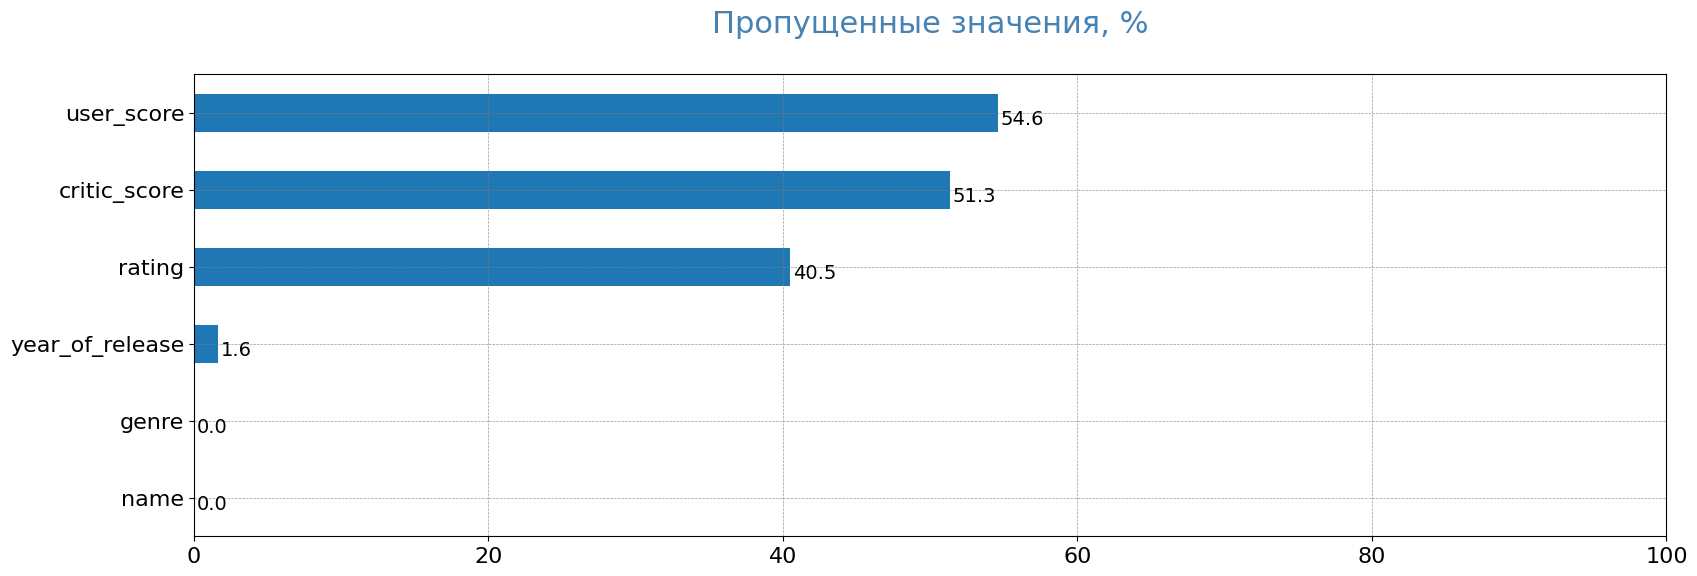

In [10]:
# выводим график
pass_value_barh(data)

Большое количество пропусков в столбцах **critic_score**, **rating** и **user_score**. Их нельзя заменить средними или медианными значениями. Скорее всего некоторые игры не оценивались, поэтому оставим пропуски как есть и будем учитывать их при дальнейшем анализе. Незначительные пропуски в **name** и **genre** даже не видно на графике. Пропусков в **year_of_release** немного, но с ними нужно что-то сделать

Посмотрим на пропуски в **year_of_release**

In [11]:
data['year_of_release'].isna().sum()

269

In [12]:
data[data['year_of_release'].isna()]['platform'].value_counts()

wii     34
ps2     34
ds      30
x360    30
ps3     25
xb      21
pc      17
2600    17
psp     16
gc      14
gba     11
3ds      8
ps       7
n64      3
psv      1
gb       1
Name: platform, dtype: int64

Так как для исследования важны данные по годам, оставшиеся пропуски в **year_of_release** придется удалить

In [13]:
data.dropna(subset=['year_of_release'], inplace=True)

Посмотрим на пропуски в **name** и **genre**

In [14]:
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,gen,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,gen,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [15]:
data[data['genre'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,gen,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,gen,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Строчки **659** и **14244** малоинформативны. Удалим их

In [16]:
data.drop([659, 14244],inplace=True)

In [17]:
# проверим
data.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating             6676
dtype: int64

Посмотрим на пропуски в столбце **rating**

In [18]:
data['rating'].value_counts()

E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
AO         1
RP         1
Name: rating, dtype: int64

Устаревшее "К-А" заменим на "Е"

In [19]:
data.loc[data['rating'] == 'K-A', 'rating'] = 'E'

In [20]:
data['rating'] = data['rating'].fillna('other')
data.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating                0
dtype: int64

### Обработка дубликатов

In [21]:
# проверка на наличие явных дубликатов
data.duplicated().sum()
data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.5+ MB


### Новый стобец - Суммарные продажи

In [22]:
# создадим столбец total_sales, где сложим продажи по регионам
data['total_sales'] = data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
 11  total_sales      16444 non-null  float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 1.6+ MB


## Исследовательский анализ данных

### Выпуск игр в разные годы

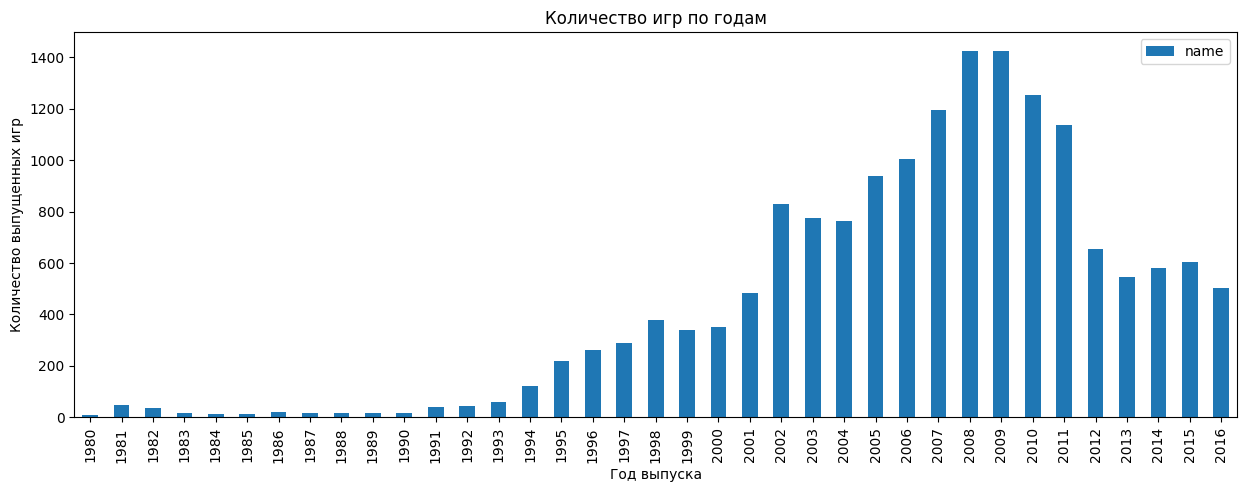

In [24]:
# построим график
(
data.pivot_table(index='year_of_release', values='name', aggfunc='count')
    .plot(kind='bar', figsize=(15, 5))
);
plt.title("Количество игр по годам")
plt.xlabel("Год выпуска")
plt.ylabel("Количество выпущенных игр");

На графике видно, что интерес к играм начал расти с 1995 года. Очевидно, это связано с развитием технологий. В 2002 проиходит резкий скачок. Промежуток с 2007 по 2009 - пик. После происходит снижение выпуска компьютерных игр. Возможные причины: экономический кризис, появление более современных устройств, у пользователей изменились требования к играм.

### Продажи по платформам

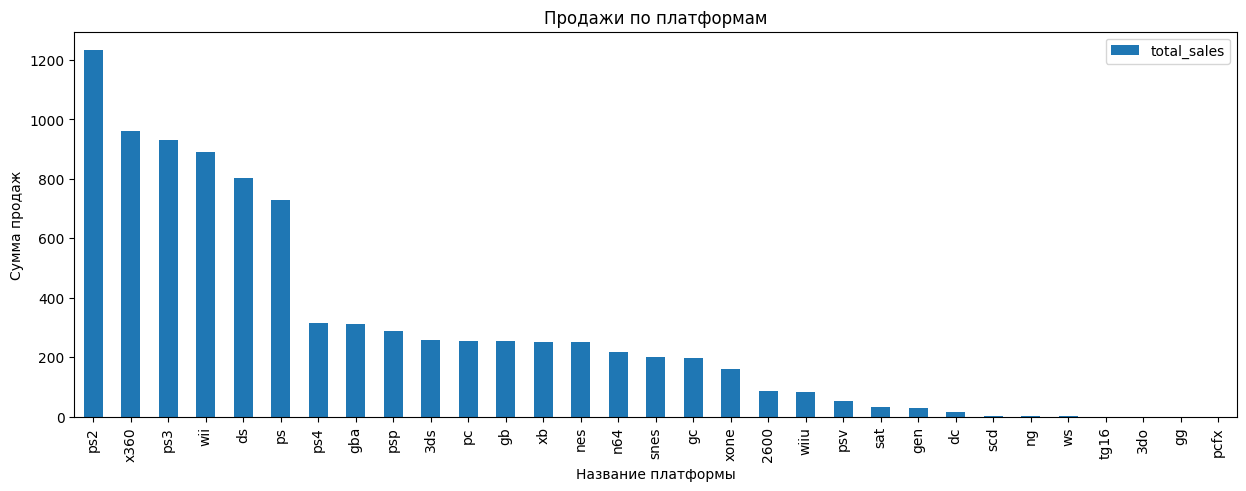

In [25]:
# построим график 
(
data.pivot_table(index='platform', values='total_sales', aggfunc='sum')
    .sort_values(by='total_sales', ascending=False)
    .plot(kind='bar', figsize=(15, 5))
);
plt.title("Продажи по платформам")
plt.xlabel("Название платформы")
plt.ylabel("Сумма продаж");

Особенно выделяются платформы PS2, X360, PS3, Wii, PS и DS. Построим по ним графики распределения по годам.

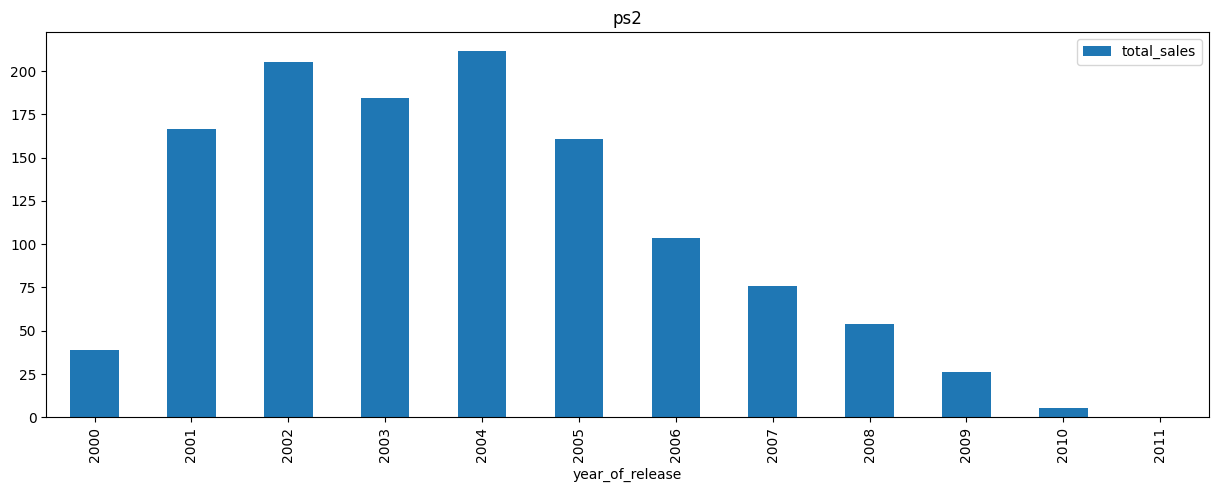

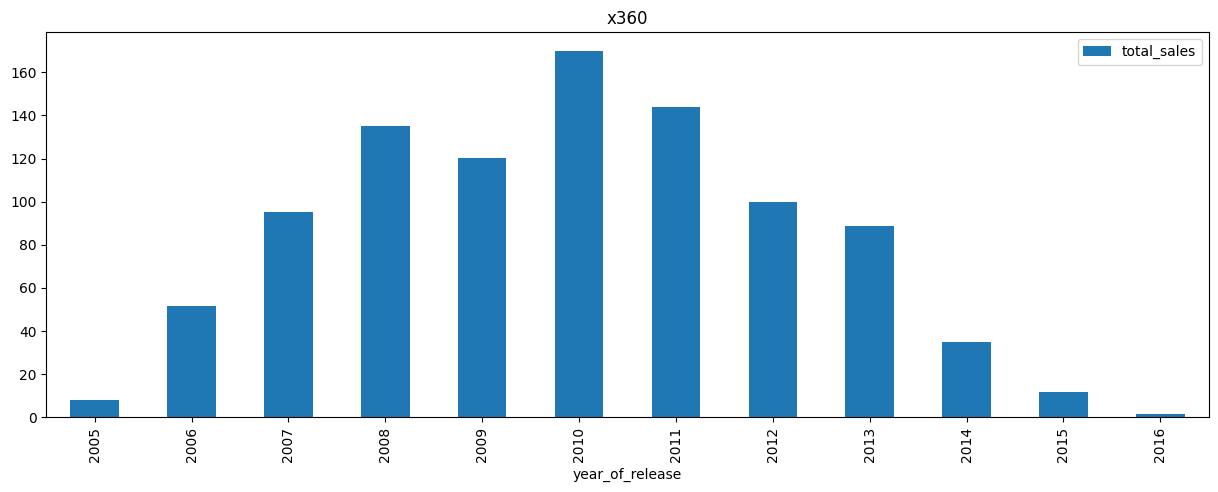

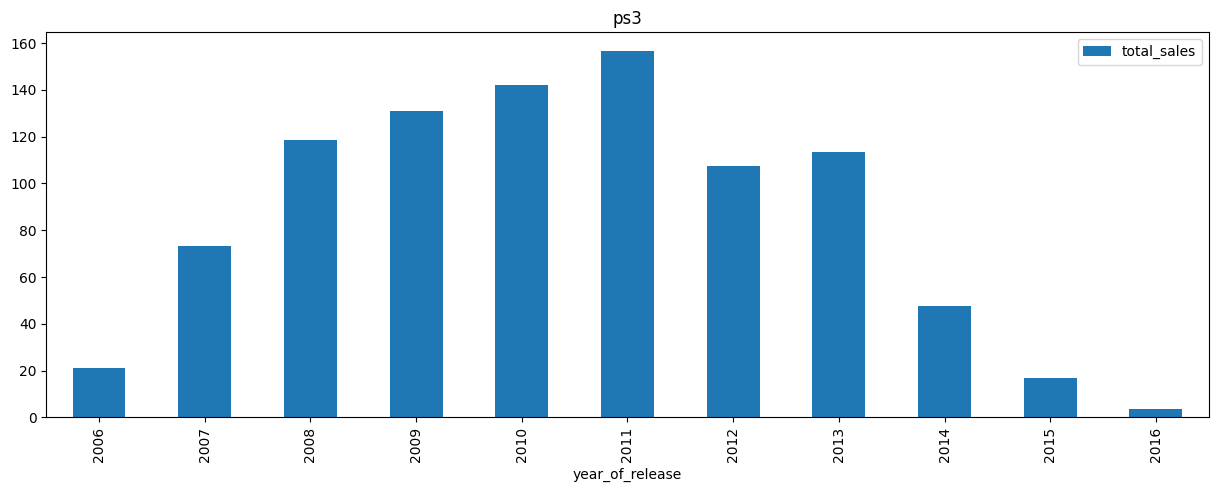

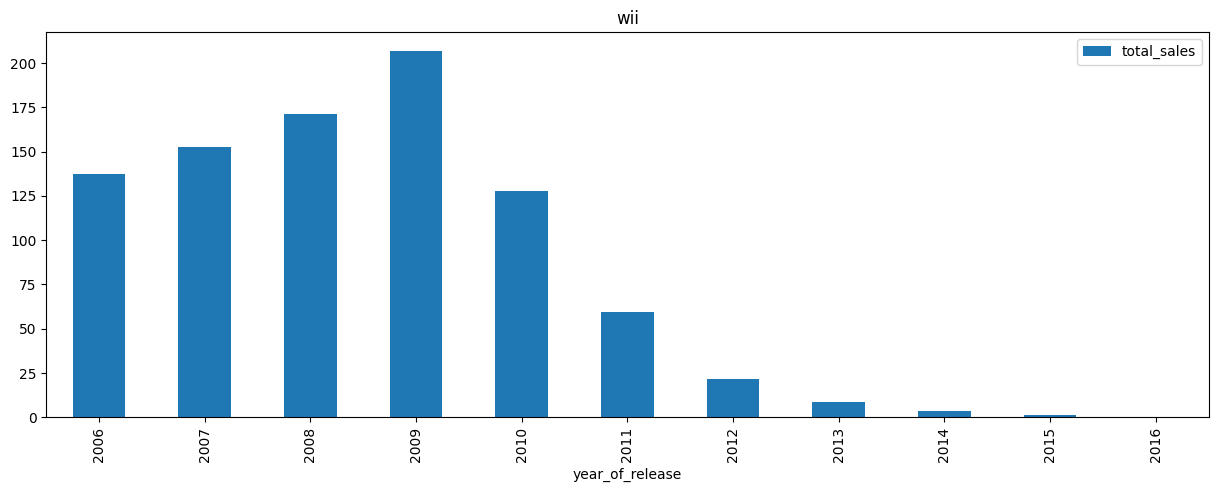

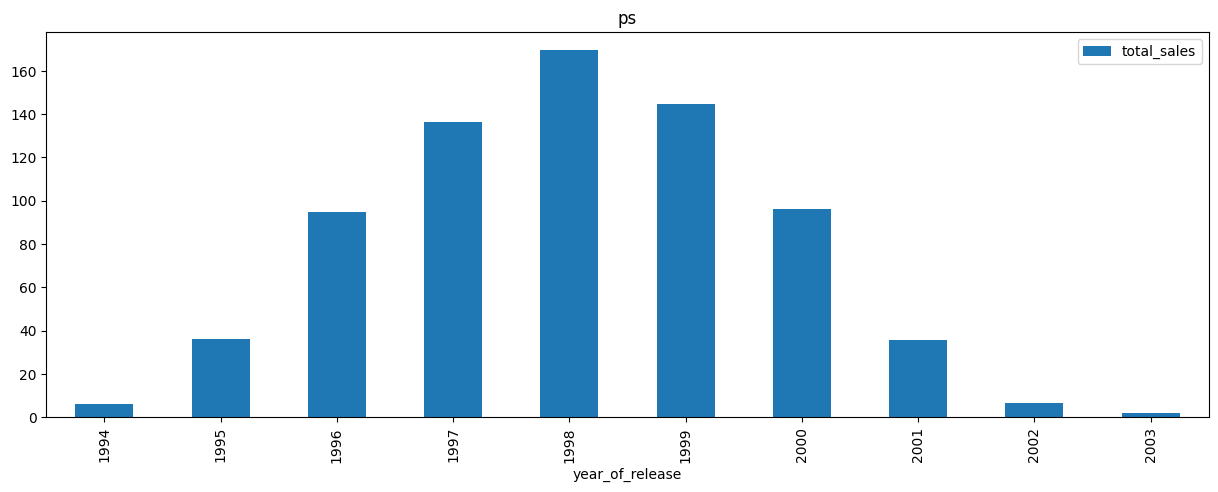

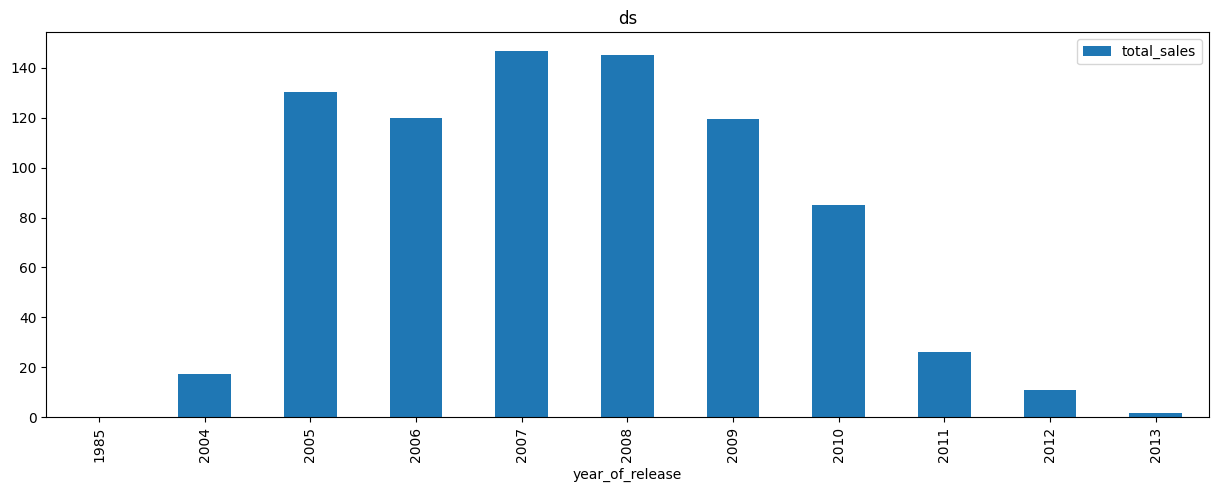

In [26]:
platform_top6 = ['ps2', 'x360', 'ps3', 'wii', 'ps', 'ds']

for platform in platform_top6:
    (data[data['platform'] == platform]
     .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
     .plot(kind='bar', figsize=(15, 5)))
    plt.title(platform)

Срок существования платформ:
* **PS2** - с 2000 по 2011, пик в 2002 и в 2004
* **X360** - с 2005 по 2016, пик в 2010
* **PS3** - с 2006 по 2016, пик 2011
* **Wii** - с 2006 по 2015, пик в 2009
* **PS** - с 1994 по 2003, пик в 1998
* **DS** - с 1985 по 2013, пик в 2005

Платформы "живут" в среднем 10-11 лет. Из тех, что поновее и дожил до 2016 года, по всем платформам наблюдается снижение продаж.

Изучим выброс у DS в 1985 году. Эту аномалию удаляем, платформу выпустили на рынок в 2004 году.

In [27]:
data.query('(platform == "ds") & (year_of_release == 1985)')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15957,strongest tokyo university shogi ds,ds,1985,action,0.0,0.0,0.02,0.0,NaN,NaN,other,0.02


In [28]:
data.drop([15957],inplace=True)

### Исследование актуальных данных

Для дальнейшего анализа возьмем промежуток времени с 2014 года по 2016.

In [29]:
# отфильтруем не нужные данные
actual_data = data.query('(year_of_release > 2013)')

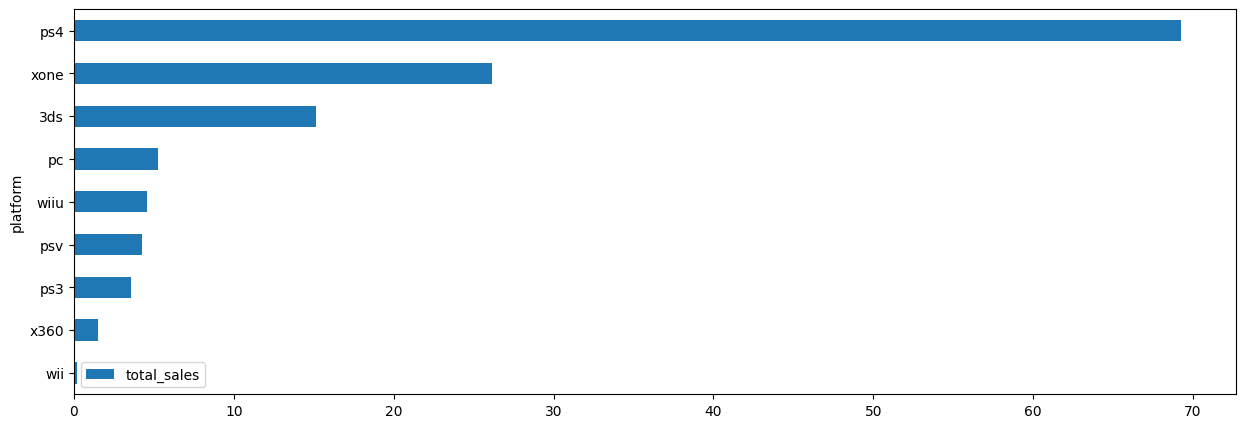

In [30]:
# выделим платформы, лидирующие по продажам на конец 2016
(
actual_data.query('year_of_release==2016')
    .pivot_table(index='platform', values='total_sales', aggfunc='sum')
    .sort_values('total_sales')
    .plot(kind='barh', figsize=(15, 5))
);

Самые потенциально прибыльные платформы:
* PS4
* XOne
* 3DS
* PC

Постороим график «ящик с усами» по глобальным продажам игр в разбивке по этим платформам

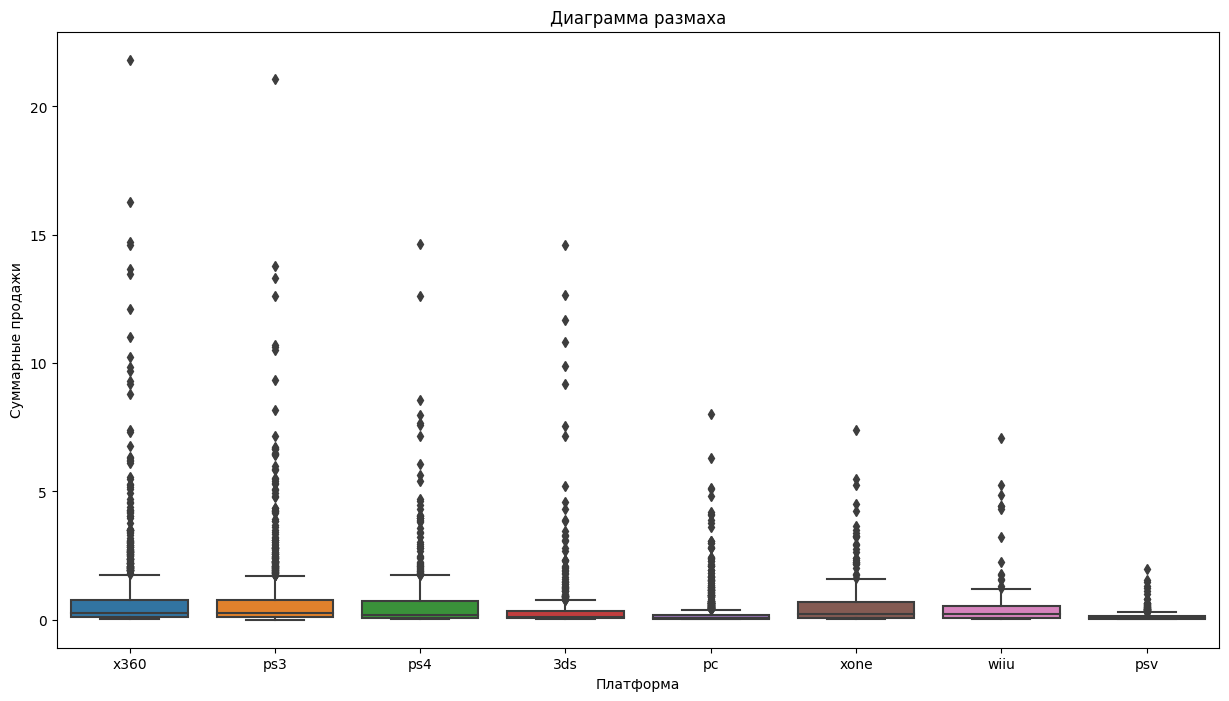

In [31]:
platforms_top = ['ps4', 'xone', 'pc', '3ds', 'wiiu', 'psv', 'ps3', 'x360']
platforms_top_games = data[data['platform'].isin(platforms_top)]

plt.figure(figsize=(15, 8))
sns.boxplot(data=platforms_top_games, x='platform', y='total_sales')
plt.title('Диаграмма размаха')
plt.xlabel('Платформа')
plt.ylabel('Суммарные продажи');

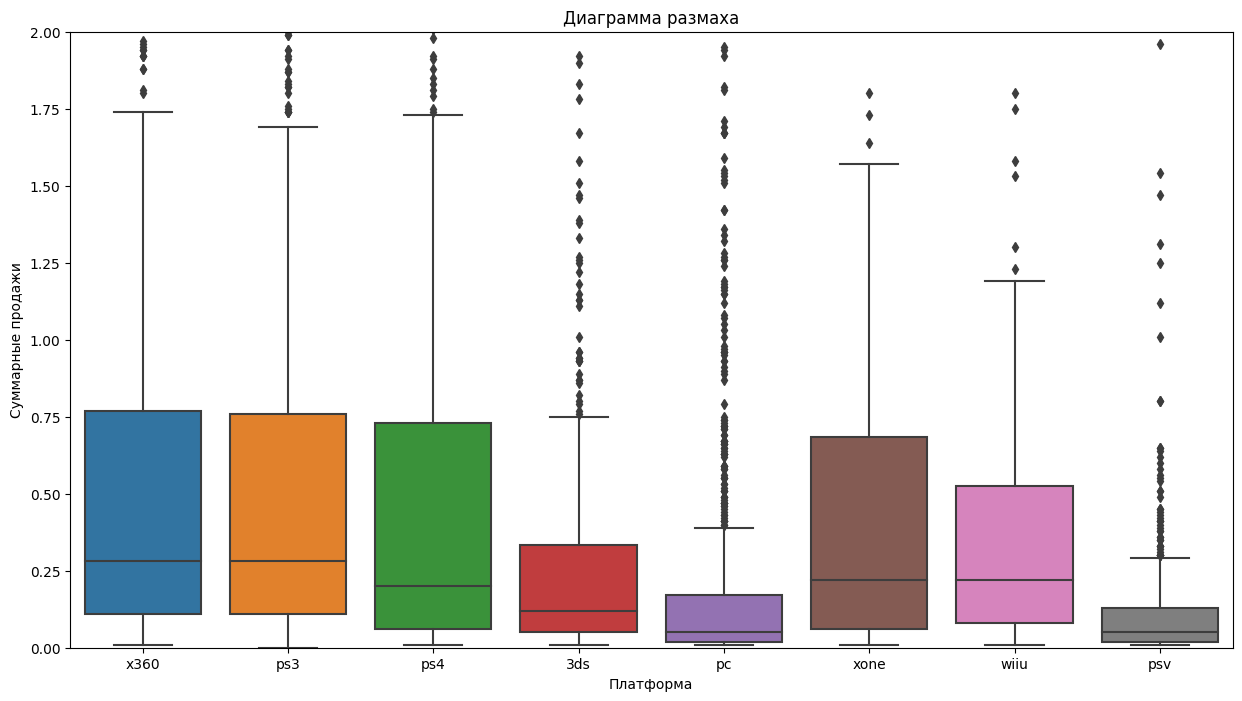

In [32]:
plt.figure(figsize=(15,8))
sns.boxplot(data=platforms_top_games, x='platform', y='total_sales')
plt.ylim(0, 2)
plt.title('Диаграмма размаха')
plt.xlabel('Платформа')
plt.ylabel('Суммарные продажи');

Медиана по платформам варьируется от 0,12 до 0,25 млн долларов прибыли за игру. Верхняя граница предела, за которыми уже определяются аномалии, у двух платформ - PS4 и XOne - на уровне 1,8 млн долларов.


Посмотрим, как влияют на продажи платформы PS4 отзывы пользователей и критиков

In [33]:
# отфильтруем пропуски
ps4_data_user = (actual_data[(actual_data['platform'] == 'ps4') & 
                             (actual_data['user_score'] > 0)])
ps4_data_critic = (actual_data[(actual_data['platform'] == 'ps4') & 
                               (actual_data['critic_score'] > 0)])

-0.04013158947269733

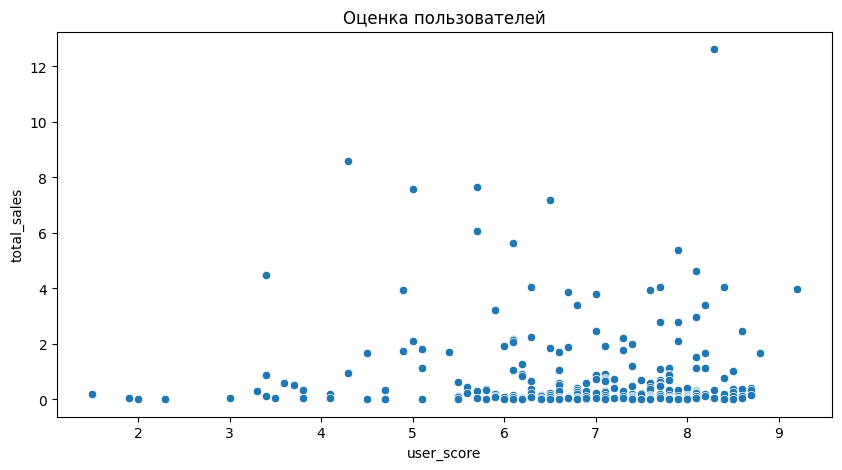

In [34]:
# построим диаграмму рассеяния
plt.figure(figsize=(10,5))
sns.scatterplot(x='user_score', y='total_sales', data=ps4_data_user);
plt.title("Оценка пользователей");
ps4_data_user['user_score'].corr(ps4_data_user['total_sales'])

0.4026614106810409

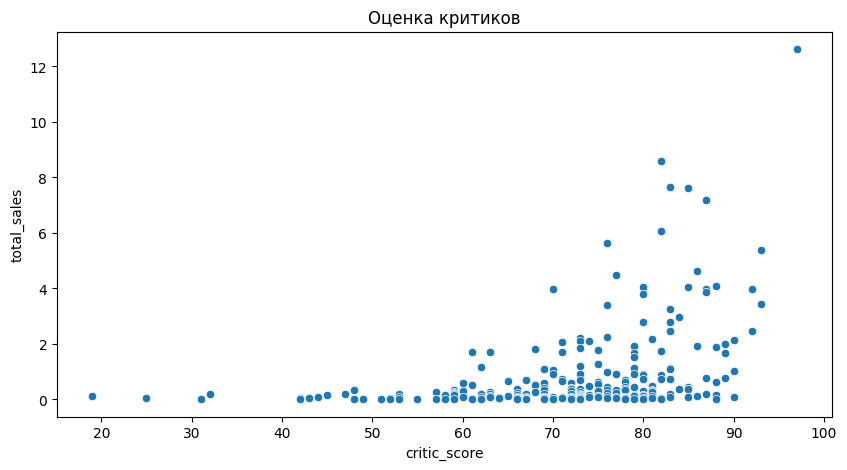

In [35]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='critic_score', y='total_sales', data=ps4_data_critic);
plt.title("Оценка критиков");
ps4_data_critic['critic_score'].corr(ps4_data_critic['total_sales'])

С увеличением среднего рейтинга как пользователей, так и критиков увеличивается и средний уровень выручки с продажи игр. На конечную стоимость больше влияет оценка критиков.

In [36]:
# отфильтруем данные по платформам-конкурентам
# PS3
ps3_data_user = (actual_data[(actual_data['platform'] == 'ps3') & 
                             (actual_data['user_score'] > 0)])
ps3_data_critic = (actual_data[(actual_data['platform'] == 'ps3') & 
                               (actual_data['critic_score'] > 0)])

# XOne
xone_data_user = (actual_data[(actual_data['platform'] == 'xone') & 
                             (actual_data['user_score'] > 0)])
xone_data_critic = (actual_data[(actual_data['platform'] == 'xone') & 
                               (actual_data['critic_score'] > 0)])

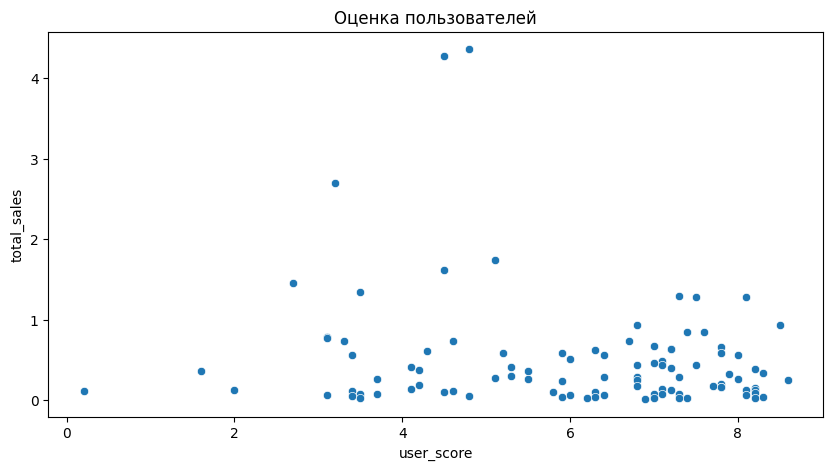

-0.16676141347662118


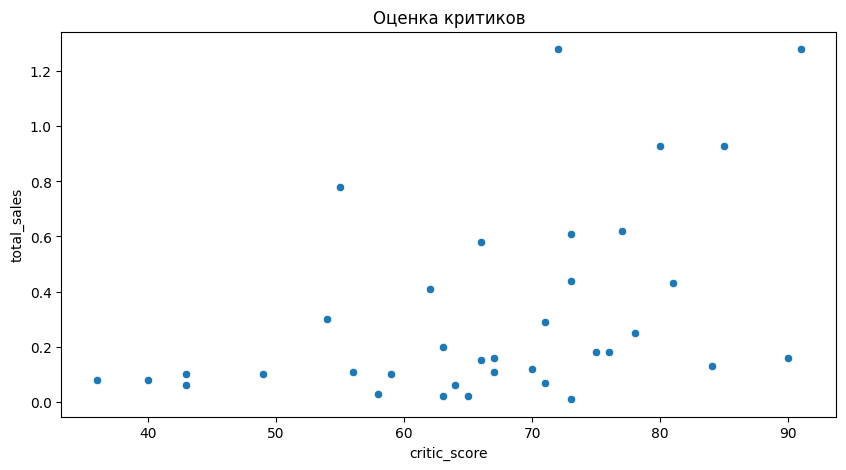

0.44657460493190704

In [37]:
# PS3
plt.figure(figsize=(10,5))
sns.scatterplot(x='user_score', y='total_sales', data=ps3_data_user)
plt.title("Оценка пользователей");
plt.show()
print(ps3_data_user['user_score'].corr(ps3_data_user['total_sales']))

plt.figure(figsize=(10,5))
sns.scatterplot(x='critic_score', y='total_sales', data=ps3_data_critic)
plt.title("Оценка критиков");
plt.show()
ps3_data_critic['critic_score'].corr(ps3_data_critic['total_sales'])

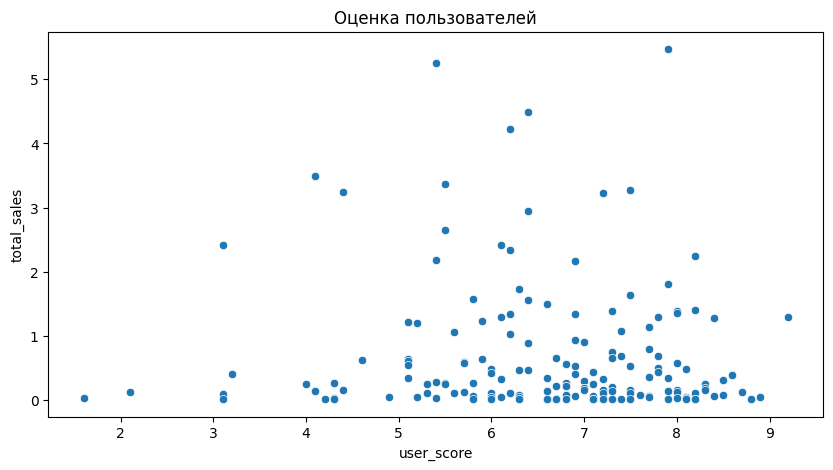

-0.07038392806475809


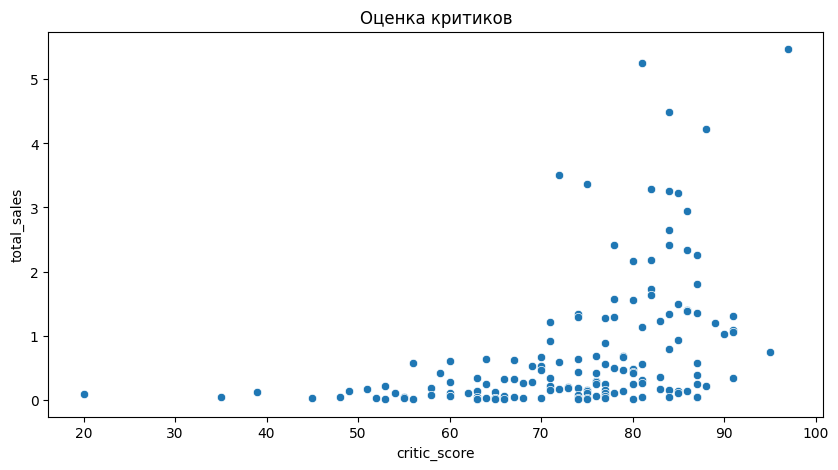

0.42867694370333187

In [38]:
# XOne
plt.figure(figsize=(10,5))
sns.scatterplot(x='user_score', y='total_sales', data=xone_data_user);
plt.title("Оценка пользователей");
plt.show()
print(xone_data_user['user_score'].corr(xone_data_user['total_sales']))

plt.figure(figsize=(10,5))
sns.scatterplot(x='critic_score', y='total_sales', data=xone_data_critic);
plt.title("Оценка критиков");
plt.show()
xone_data_critic['critic_score'].corr(xone_data_critic['total_sales'])

Данные по другим платформам почти совпадают с продажами самой популярной платформы. Небольшая зависимость продаж с мнением критиков присутсвует. 

In [39]:
# распределение игр по жанрам
genre_and_sales = actual_data.pivot_table(index='genre', values='total_sales', aggfunc=['count', 'sum'])
genre_and_sales.columns = ['Количество', 'Продажи']
genre_and_sales.sort_values('Продажи', ascending=False)

,Количество,Продажи
genre,,
action,619,199.36
shooter,128,170.94
sports,161,109.48
role-playing,221,101.44
misc,113,37.55
fighting,60,28.22
racing,69,27.52
platform,38,18.09
adventure,185,17.55


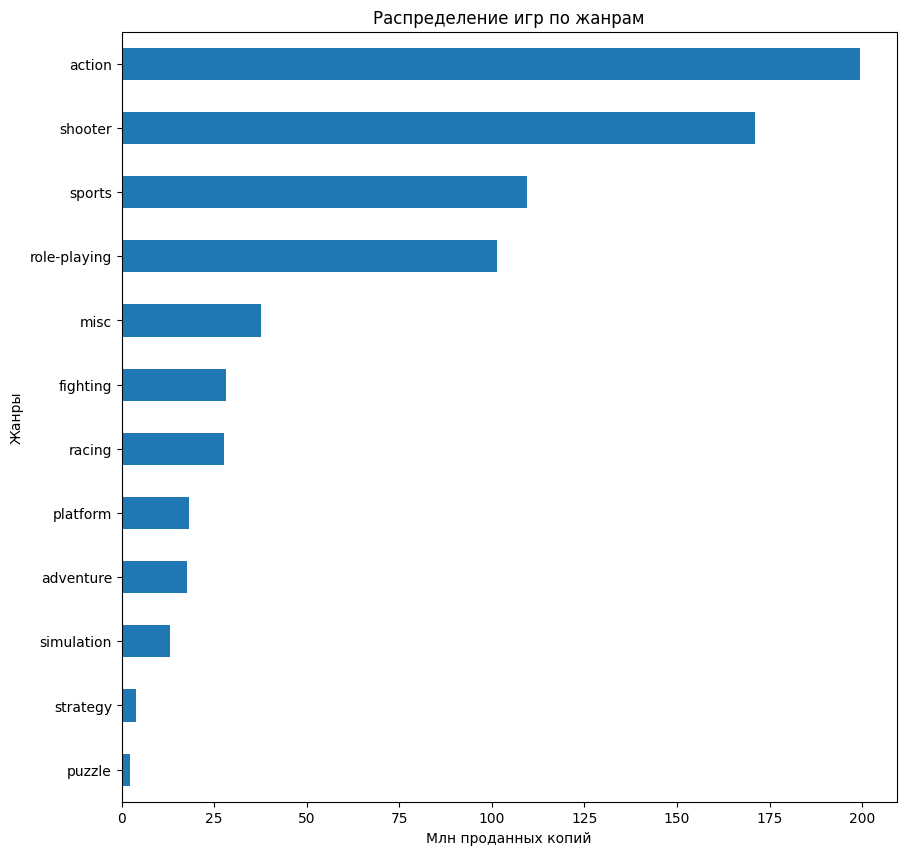

In [40]:
(
genre_and_sales['Продажи'].sort_values()
    .plot(kind='barh', figsize=(10, 10))
);
plt.title("Распределение игр по жанрам")
plt.xlabel("Млн проданных копий")
plt.ylabel("Жанры");

Самые популярные жанры игр: Action, Sport, Shooter

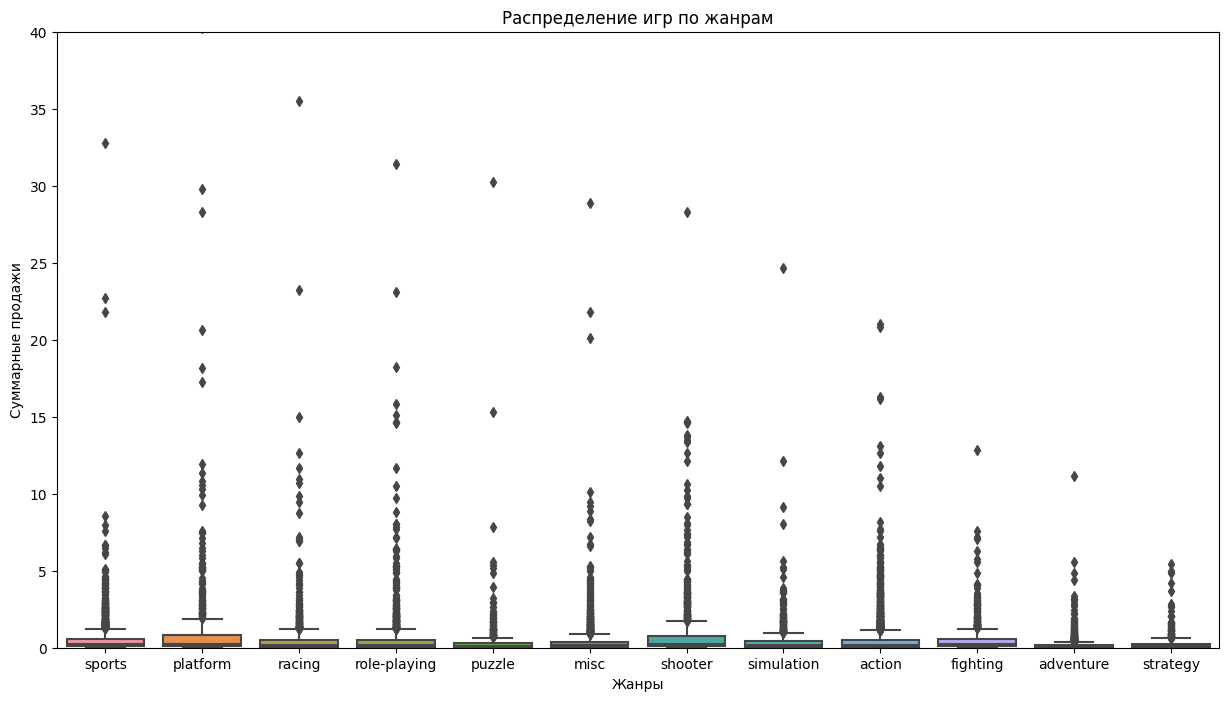

In [41]:
plt.figure(figsize=(15,8))
sns.boxplot(x=data['genre'], y=data['total_sales'])
plt.title('Распределение игр по жанрам')
plt.ylim(0, 40)
plt.xlabel('Жанры')
plt.ylabel('Суммарные продажи');

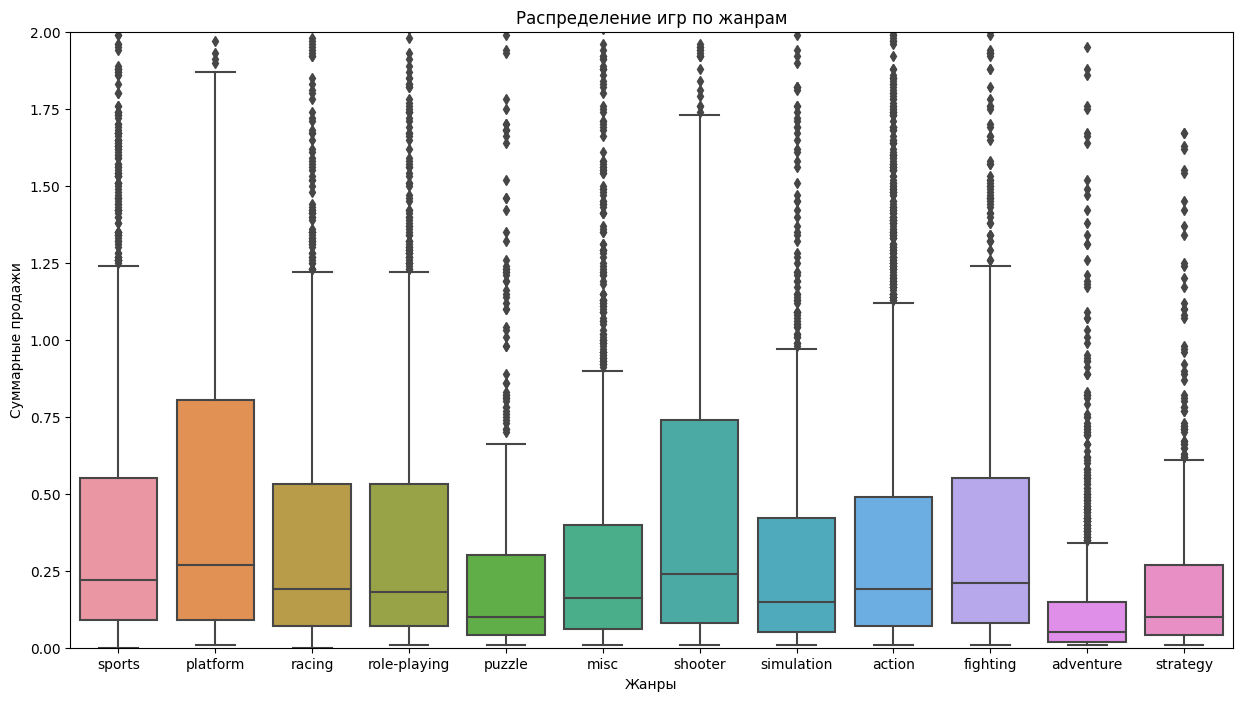

In [42]:
plt.figure(figsize=(15,8))
sns.boxplot(x=data['genre'], y=data['total_sales'])
plt.ylim(0, 2)
plt.title('Распределение игр по жанрам')
plt.xlabel('Жанры')
plt.ylabel('Суммарные продажи');

## Портрет пользователя по регионам

Необходимо узнать:
* Самые популярные платформы (топ-5). Опишите различия в долях продаж.
* Самые популярные жанры (топ-5). Поясните разницу.
* Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [43]:
# платформы
# Северная Америка 
na_platform = (actual_data
               .pivot_table(index='platform', values='na_sales', aggfunc='sum')
               .sort_values('na_sales', ascending=False))

na_platform5 = na_platform[:5].copy()
na_platform5.loc['other', 'na_sales'] = na_platform[5:]['na_sales'].sum()

# Европа 
eu_platform = (actual_data
               .pivot_table(index='platform', values='eu_sales', aggfunc='sum')
               .sort_values('eu_sales', ascending=False))

eu_platform5 = eu_platform[:5].copy()
eu_platform5.loc['other', 'eu_sales'] = eu_platform[5:]['eu_sales'].sum()

# Япония 
jp_platform = (actual_data
               .pivot_table(index='platform', values='jp_sales', aggfunc='sum')
               .sort_values('jp_sales', ascending=False))

jp_platform5 = jp_platform[:5].copy()
jp_platform5.loc['other', 'jp_sales'] = jp_platform[5:]['jp_sales'].sum()

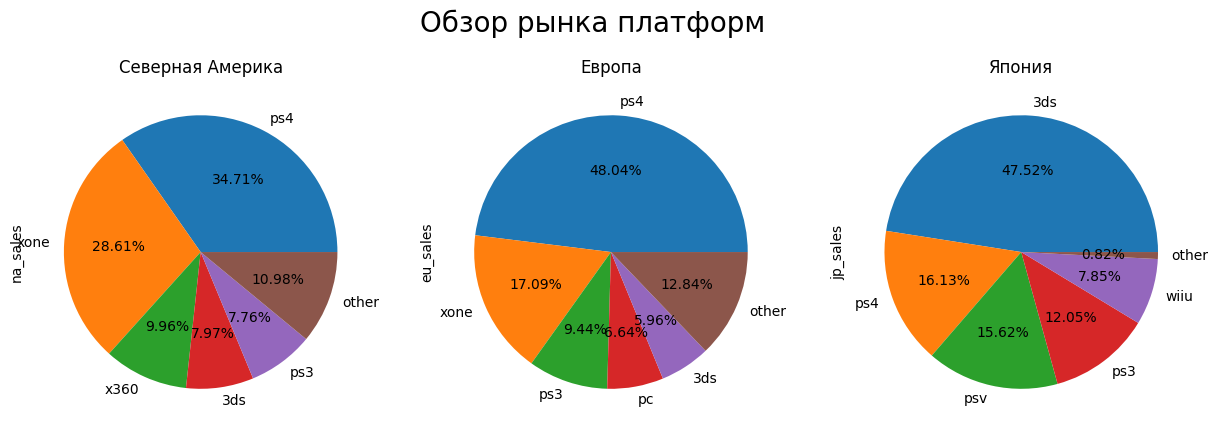

In [44]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(15, 5)
fig.suptitle('Обзор рынка платформ', fontsize = 20)

na_platform5.plot.pie(subplots=True, ax=ax1, legend=False,  autopct='%.2f%%')
ax1.set_title('Северная Америка')

eu_platform5.plot.pie(subplots=True, ax=ax2, legend=False,  autopct='%.2f%%')
ax2.set_title('Европа')

jp_platform5.plot.pie(subplots=True, ax=ax3, legend=False,  autopct='%.2f%%')
ax3.set_title('Япония');

Разница в продажах возникает из-за особенностей рынка того или иного региона. Получается, что это зависит от влияния самой фирмы в конкретном регионе.

In [45]:
# жанры
# Северная Америка 
na_genre = (actual_data
            .pivot_table(index='genre', values='na_sales', aggfunc='sum')
            .sort_values('na_sales', ascending=False))

na_genre5 = na_genre[:5].copy()
na_genre5.loc['other', 'na_sales'] = na_genre[5:]['na_sales'].sum()

# Европа
eu_genre = (actual_data
            .pivot_table(index='genre', values='eu_sales', aggfunc='sum')
            .sort_values('eu_sales', ascending=False))

eu_genre5 = eu_genre[:5].copy()
eu_genre5.loc['other', 'eu_sales'] = eu_genre[5:]['eu_sales'].sum()

# Япония 
jp_genre = (actual_data
            .pivot_table(index='genre', values='jp_sales', aggfunc='sum')
            .sort_values('jp_sales', ascending=False))

jp_genre5 = jp_genre[:5].copy()
jp_genre5.loc['other', 'jp_sales'] = jp_genre[5:]['jp_sales'].sum()

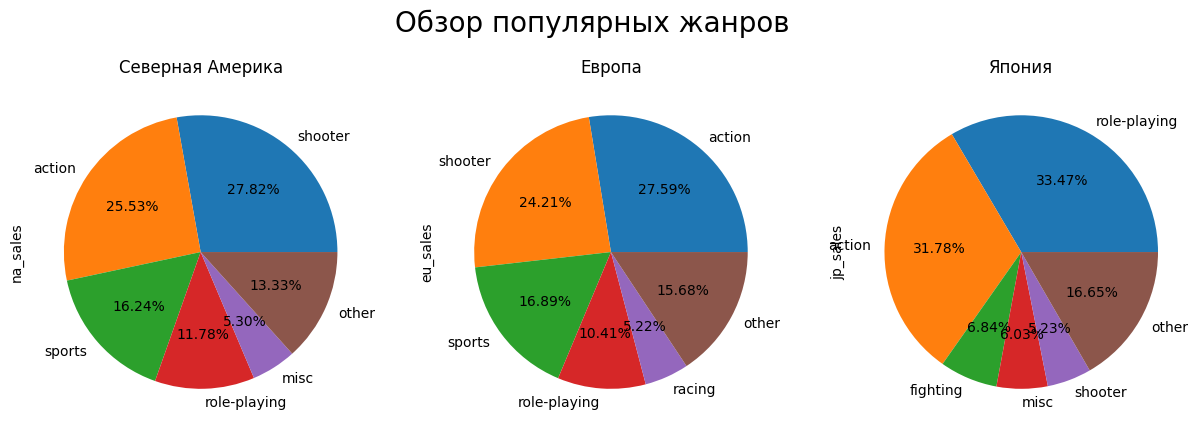

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(15, 5)
fig.suptitle('Обзор популярных жанров', fontsize = 20)

na_genre5.plot.pie(subplots=True, ax=ax1, legend=False,  autopct='%.2f%%')
ax1.set_title('Северная Америка')

eu_genre5.plot.pie(subplots=True, ax=ax2, legend=False,  autopct='%.2f%%')
ax2.set_title('Европа')

jp_genre5.plot.pie(subplots=True, ax=ax3, legend=False,  autopct='%.2f%%')
ax3.set_title('Япония');

Во всех случаях кроме Японии лидируют жанры Action, Sport и Shooter. Отличие Японии видимо заключается в особенном менталитете.

In [47]:
# рейтинг
# отфильтруем пропуски
# rating_data = actual_data[actual_data['rating'].notnull()]

# Северная Америка
na_rating = (actual_data
             .pivot_table(index='rating', values='na_sales', aggfunc='sum')
             .sort_values('na_sales', ascending=False))

# Европа
eu_rating = (actual_data
             .pivot_table(index='rating', values='eu_sales', aggfunc='sum')
             .sort_values('eu_sales', ascending=False))
    
# Япония 
jp_rating = (actual_data
             .pivot_table(index='rating', values='jp_sales', aggfunc='sum')
             .sort_values('jp_sales', ascending=False))

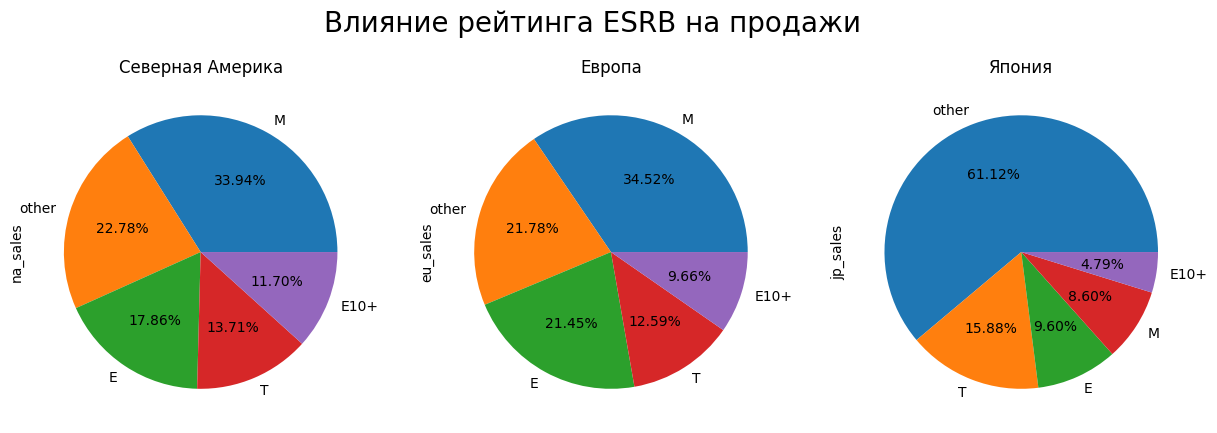

In [48]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(15, 5)
fig.suptitle('Влияние рейтинга ESRB на продажи', fontsize = 20)

na_rating.plot.pie(subplots=True, ax=ax1, legend=False,  autopct='%.2f%%')
ax1.set_title('Северная Америка')

eu_rating.plot.pie(subplots=True, ax=ax2, legend=False,  autopct='%.2f%%')
ax2.set_title('Европа')

jp_rating.plot.pie(subplots=True, ax=ax3, legend=False,  autopct='%.2f%%')
ax3.set_title('Япония');

Самый популярный ретйинг по регионам M - от 17 лет.За ним следует рейтинги E - "для всех",T - от 13 лет. Рынки по регионам на целены на глобального пользователя, то есть любого возраста.

## Проверка гипотез

1) Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

2) Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

### Гипотеза №1

**Н0 (нулевая гипотеза)** - средние пользовательские рейтинги платформ Xbox One и PC **равны**.

**Н1 (альтернативная гипотеза)** - средние пользовательские рейтинги платформ Xbox One и PC отличаются между собой.

In [49]:
# отбираем данные
xbox_data = actual_data[(actual_data['platform'] == 'xone') & (actual_data['user_score'] > 0)]['user_score']
pc_data = actual_data[(actual_data['platform'] == 'pc') & (actual_data['user_score'] > 0)]['user_score']

In [50]:
alpha = .05

results = st.ttest_ind(xbox_data, pc_data)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.10450507919348415
Не получилось отвергнуть нулевую гипотезу


Полученное значение говорит нам о том, что примерно в 10% случаев различия в среднем пользовательском рейтинге платформ Xbox One и PC будет случайным.

### Гипотеза №2

**Н0 (нулевая гипотеза)** - средние пользовательские рейтинги жанров Action и Sports одинаковые.

**Н1 (альтернативная гипотеза)** - средние пользовательские рейтинги жанров Action и Sports отличаются между собой.

In [51]:
# отбираем данные
action_data = actual_data[(actual_data['genre'] == 'action') & (actual_data['user_score'] > 0)]['user_score']
sports_data = actual_data[(actual_data['genre'] == 'sports') & (actual_data['user_score'] > 0)]['user_score']

In [52]:
alpha = .05

results = st.ttest_ind(action_data, sports_data)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.8711147985105864e-19
Отвергаем нулевую гипотезу


Маловероятно, что средние пользовательские рейтинги жанров Action и Sports будут равны.

## Общий вывод

В ходе исследования была выполнена предобработка данных: обработка пропусков, дубликатов, заменены типы данных. Проведен ИАД: проанализированы продажи по разным годам, различным платформам, исследована зависимость продаж от оценки пользователей и критиков, проанализировано распредление жанров по продажам. Составлен порстрет пользователя по регионам. Проверены две гипотезы.

Результаты:
1. Платформы "живут" в среднем 10-11 лет. Заметно снижение продаж по всем платформам, что связано скорее всего с упадком интереса пользователей.
2. Самые потенциально прибыльные платформы: PS4, XOne, 3DS, PS
3. Средняя цена варьируется от 0,12 до 0,25 млн долларов прибыли за игру.
4. С увеличением среднего рейтинга как пользователей, так и критиков увеличивается и средний уровень выручки с продажи игр. На конечную стоимость больше влияет оценка критиков.
5. Самые популярные жанры игр: Action, Sport, Shooter

В Северной Америке самые популярные платформы PS4 (25%), XOne (21%) и X360 (19%). В Европе - PS4 (36%), PS3 (17%), XOne (13%). В Японии - 3DS (48%), PS3 (17%), PSV (13%). В плане жанров пользовательские предпочтения в Америке и в Европе совпадают. Япония отличилась - 1/3 пользователей выбирает Role-playing (36%), затем идет Action (29%). На основе рейтинга определили, что основная аудитория во всех трех странах, на которую ориентированы производители, это "старше 17 лет".